In [37]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/work/Data Science/sheffield-bats


In [38]:
import torch
from segmentation_models_pytorch import Unet
import rasterio as rio
# Define windows from block size
from rasterio.windows import Window
from typing import Tuple, Union
from pathlib import Path
import pandas as pd

# Set Up Dataset

In [39]:
species_counts = pd.read_csv('data/processed/bat-species-counts.csv')
species_counts["count_weight"] = species_counts["total_records"] / species_counts["total_records"].sum()
species_counts

,species,total_records,count_weight
0,Pipistrellus pygmaeus,517,0.055247
1,Plecotus auritus,470,0.050224
2,Pipistrellus pipistrellus,3343,0.357234
3,Unknown,1286,0.137423
4,Pipistrellus sp.,1327,0.141804
5,Myotis sp.,426,0.045523
6,Nyctalus noctula,472,0.050438
7,NaN,37,0.003954
8,Nyctalus leisleri,161,0.017205
9,Myotis daubentonii,703,0.075123


In [40]:
ev_path = "data/processed/s2-dtm-100m.tif"
presences_path = "data/processed/bat-species-counts.tif"


In [41]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


def generate_tif_blocks(tif_path:Union[str, Path], block_size:int, all_even:bool=False) -> list[Window]:
    windows = []
    with rio.open(tif_path) as src:
        height, width = src.height, src.width
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                block_height = min(block_size, height - i)
                block_width = min(block_size, width - j)
                if all_even and (block_height == block_size) and (block_width == block_size):
                    windows.append(Window(j, i, block_width, block_height))
                elif not all_even:
                    windows.append(Window(j, i, block_width, block_height))
                else:
                    pass
    return windows


class SDMDataset(Dataset):
    "Dataset for training SDM models"
    def __init__(self, ev_path, presence_path, block_size=256):
        self.ev_path = ev_path
        self.presence_path = presence_path
        self.ev_info = self._get_tif_info(ev_path)
        self.presence_info = self._get_tif_info(presence_path)
        self.compare_tifs(self.ev_info, self.presence_info)
        self.windows = generate_tif_blocks(ev_path, block_size, all_even=True)
    def compare_tifs(self, ev_info, presence_info):
        """"
        Check that important components of the two tifs are the same

        Args:
        ev_info (dict): Information about the environmental variable tif
        presence_info (dict): Information about the presence tif

        """
        assert ev_info["height"] == presence_info["height"], "Height mismatch"
        assert ev_info["width"] == presence_info["width"], "Width mismatch"
        assert ev_info["crs"] == presence_info["crs"], "CRS mismatch"
        assert ev_info["transform"] == presence_info["transform"], "Transform mismatch"
        
        return True
    
    def _get_tif_info(self, tif_path):
        """
        Get information about the tif file
        """
        with rio.open(tif_path) as src:
            return {"profile": src.profile, "transform": src.transform, "crs": src.crs, "channels": src.count, "height": src.height, "width": src.width}

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        with rio.open(self.ev_path) as src:
            ev_block = src.read(window=self.windows[idx])
        with rio.open(self.presence_path) as src:
            presence_block = src.read(window=self.windows[idx])
        # Convert to Tensors
        ev_block = torch.tensor(ev_block).float()
        presence_block = torch.tensor(presence_block).float()
        presence_block = (presence_block > 0).type(torch.uint8)
        
        return ev_block, presence_block

dataset = SDMDataset(ev_path, presences_path)



In [43]:
from tqdm import tqdm
presences = [pres for _, pres in tqdm(dataset, total=len(dataset))]
presences = torch.stack(presences)


  3%|▎         | 42/1312 [00:09<04:33,  4.65it/s]


KeyboardInterrupt: 

In [ ]:
presences.shape

In [ ]:

train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)


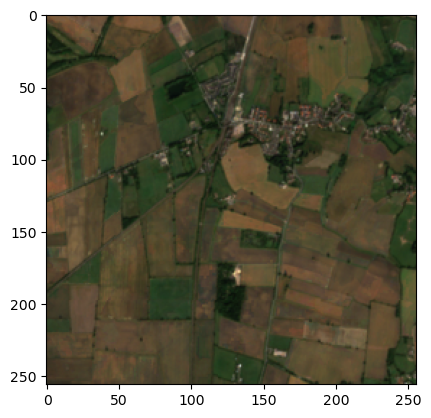

In [20]:

ev_block, presence_block = dataset[64]

import matplotlib.pyplot as plt
import numpy as np
# ev block bands align with sentinel 2 bands
# get rgb and plot
r = ev_block[3]
g = ev_block[2]
b = ev_block[1]
rgb = torch.stack([r, g, b], dim=0)
rgb = rgb.permute(1, 2, 0)
plt.imshow(rgb)


# Model

In [21]:
model = Unet("resnet34", in_channels=dataset.ev_info["channels"], classes=dataset.presence_info["channels"])
device = torch.device("mps")
model = model.to(device)

# Loss Function

In [35]:
import torch
import torch.nn as nn
class FullAssumeNegativeLoss(nn.Module):
    def __init__(self, species_weights, lambda_pres=1.0):
        super(FullAssumeNegativeLoss, self).__init__()
        self.lambda_pres = lambda_pres
        self.species_weights = species_weights

    def forward(self, predictions, combined_targets):
        # predictions: (batch_size, num_species, height, width)
        # combined_targets: (batch_size, num_species, height, width)

        # Presence mask where targets are 1
        presence_mask = combined_targets == 1
        
        # Compute the sum of other species presence for each pixel
        other_species_sum = torch.sum(combined_targets, dim=1, keepdim=True) - combined_targets

        # Target-group background mask: species absent but others present
        target_group_mask = (combined_targets == 0) & (other_species_sum > 0)
        # Random background mask: species absent and no others present
        random_bg_mask = (combined_targets == 0) & (other_species_sum == 0)

        # Compute the loss components
        presence_loss = -torch.log(predictions) * presence_mask.float() * self.lambda_pres
        target_group_loss = -torch.log(1 - predictions) * target_group_mask.float()
        random_bg_loss = -torch.log(1 - predictions) * random_bg_mask.float()

        # Apply species weights
        presence_loss = presence_loss * self.species_weights[None, :, None, None]
        target_group_loss = target_group_loss * self.species_weights[None, :, None, None]
        random_bg_loss = random_bg_loss * self.species_weights[None, :, None, None]

        # Sum losses
        total_loss = (presence_loss + target_group_loss + random_bg_loss).mean()

        return total_loss

weights = (species_counts["count_weight"].max() + 0.01 / species_counts["count_weight"] + 0.01) + (1- species_counts["count_weight"].min())
print(weights)
weights = torch.tensor(weights.values, device=device, dtype=torch.float32)
criterion = FullAssumeNegativeLoss(species_weights=weights)

# Test the loss function
predictions = torch.rand(1, 1, 256, 256).to(device)
combined_targets = torch.zeros(1, 1, 256, 256).to(device)
combined_targets[0, 0, 100:150, 100:150] = 1
loss = criterion(predictions, combined_targets)
print(loss)

0      1.547920
1      1.566020
2      1.394907
3      1.439682
4      1.437434
5      1.586585
6      1.565177
7      3.896103
8      1.948156
9      1.500029
10     5.266081
11     1.605638
12     3.401262
13     1.999211
14    32.560247
15    32.560247
Name: count_weight, dtype: float64
tensor(5.9615, device='mps:0')


In [36]:
import lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import AUROC

auc_metric = AUROC(task="multilabel", num_labels=dataset.presence_info["channels"])

class SDMModel(pl.LightningModule):
    def __init__(self, model, criterion, val_metric, device="mps"):
        super(SDMModel, self).__init__()
        self.model = model.to(self.device)
        self.criterion = criterion.to(self.device)
        self.val_metric = val_metric

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        auc = self.val_metric(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_auc", auc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


model = SDMModel(model, criterion, auc_metric)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/bats/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | SDMModel               | 24.5 M | train
1 | criterion  | FullAssumeNegativeLoss | 0      | train
2 | val_metric | MultilabelAUROC        | 0      | train
--------------------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.880    Total estimated model params size (MB)
/opt/homebrew/anaconda3/envs/bats/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck.

Training: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/bats/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


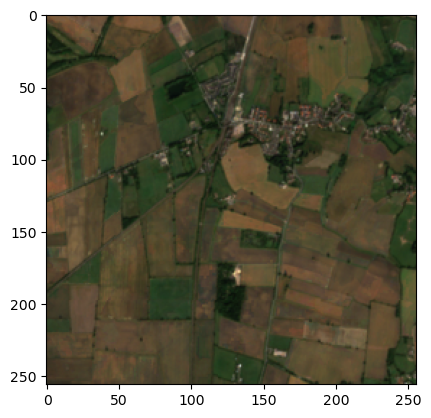

In [16]:
trainer.model.eval()
x, y = dataset[64]
x = x.unsqueeze(0).to(device)
y_hat = trainer.model(x)
y_hat = y_hat.squeeze().cpu().detach().numpy()


r, g, b = x[0, 3], x[0, 2], x[0, 1]
rgb = torch.stack([r, g, b], dim=0)
rgb = rgb.permute(1, 2, 0)
plt.imshow(rgb.cpu().detach().numpy())
